You can either download this notebook and run it locally, or you can run it in the cloud:<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_Image_Visualization_with_itkWidgets.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/kirbyju/TCIA_Notebooks/blob/main/TCIA_Image_Visualization_with_itkWidgets.ipynb)

# Summary
Interacitve visualization of data is essential to AI research. It is used to validate how the data is being read and pre-processed.  Overlays (labelmaps) on images allow annotations and segmentation results to be evaluated and enable strengths and weaknesses to be identified and documented. Visualization is also critical in communication with collaborators.

[The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute which addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers. Its rich collection of clinical data and annotations is particularly powerful as a community resource when it is paired with interactive code systems, such as Jupyter systems.

While jupyter systems (jupyter labs, jupyter notebooks, Google CoLab, AWS SageMaker, etc.) are outstanding tools for interactive programming and algorithm sharing, the ability to visualize data within them has traditionally be limited to plots and sparse 2D slices - which are insufficient when dealing with 3D clinical data. This limitation is particularly challenging when using cloud-based jupyter systems such as Google CoLab and AWS Sagemaker.  3D interactive visualization of data when using those cloud systems traditionally requires downloading that data to your local machine and then running a separate visualization application. itkWidgets addresses those visualization challenges by providing interacitve 3D (and 2D) visualizations within the cells of your jupyter scripts.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) allows researchers to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyer notebooks, Jupyter lab, AWS Sagemaker, and Google CoLab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualization numpy arrays, torch tensors, DASK arrays, VTK polydata, and a multitude of other python data structures.

# Outline

1. Setup
2. TCIA Basics
3. itkWidgets Basics
4. Use Cases
    1. Cinematic volume rendering of images
    2. Visualization of numpy arrays
    3. Visualization of pytorch tensors
    4. Visualization of images and overlays

# 1. Setup

These are the initial steps for running notebooks within various jupyter environments.

In [1]:
import os
import sys

# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

     |████████████████████████████████| 2.1 MB 4.1 MB/s 


In [ ]:
# If running on sagemaker or studiolab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

**On many systems you must manually install the imjoy-jupyter-extension!!**

If you do not see a blue 'ImJoy' icon on the menu bar in this notebook:
   1) Enable Extensions:  Many Jupyter Lab systems disable jupyter extensions by default,
      and they must be enabled for this notebook to work.
      Use the Jupyter interface to select the extension manager (left-hand side, icon that
      looks like a piece of a puzzle) and select the Enable button if it appears.
   2) Install imjoy extension: In the extension manager, search for 'imjoy' and install
      the 'imjoy-jupyter-extension'.
      The installation can take several minutes. It may also prompt you to rebuild, save,
      and reload your jupyter environment as part of this process.  In the end, you should see
      a blue 'ImJoy' icon on the left side of the menu bar in this notebook.

# 2. TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.  Additional details about **tcia_utils.py** can also be found there, which we'll leverage in this notebook to make it easier to grab our data to visualize.

In [2]:
# Install requests for downloading data.
!{sys.executable} -m pip install --upgrade -q requests
!{sys.executable} -m pip install --upgrade -q pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 61.8 MB/s eta 0:00:00


In [3]:
import requests

tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

In [4]:
import tcia_utils as tcia

In [5]:
# Download a "Shared Cart" that has been previously 
#    created via the NBIA webset 
#    (https://nbia.cancerimagingarchive.net)
# cartName = "nbia-77761668716072016" # Their example shared cart
cartName = "nbia-47881669847357616" # Our lung cancer data's first subject

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-47881669847357616
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832901632590301540805
Download Complete: 2 Series Instance UIDs (scans).


,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,3.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,2.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0


In [6]:
# For this demo...

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"

# Additionally we'll install numpy and torch to explore a variety of 
#    image data structures
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 58.7 MB/s eta 0:00:00


In [7]:
# Include ITK for DICOM reading
import itk

# Numpy for numpy.arrays
import numpy as np

# Torch for torch.tensors
import torch

In [8]:
# Use the data frame to find the Series UID where the Modality is CT
dicom_data_dir = "tciaDownload/"
ct_series_uid = df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
dicom_ct_dir = os.path.join(dicom_data_dir, ct_series_uid)

# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_image_large = itk.imread(dicom_ct_dir, itk.F)

# To save time for this demo, we subsample the image in the x and y dimensions
new_spacing = list(dicom_image_large.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image = itk.resample_image_filter(Input=dicom_image_large,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_large.GetOrigin(), 
                                        output_direction=dicom_image_large.GetDirection(),
                                        size=new_size)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

New spacing = [2.525390625, 2.525390625, 5.0]
New size = [170, 170, 64]


In [9]:
ct_series_uid

'1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315'

In [10]:
dicom_ct_dir

'tciaDownload/1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315'

In [11]:
spacing = list(dicom_image_large.GetSpacing())
spacing

[0.841796875, 0.841796875, 5.0]

In [12]:
spacing[:2] = [x*3 for x in spacing[:2]]
spacing

[2.525390625, 2.525390625, 5.0]

# 3. itkWidget Basics

[itkWidgets documentation](https://itkwidgets.readthedocs.io/en/latest/?badge=latest) provides a summary and illustrations of itkWidgets for a wide variety of scientific data visualization use cases.  Here we focus on its application to data on TCIA.

In [13]:
# This is the installation required for itkWidgets
!{sys.executable} -m pip install --upgrade --pre -q "itkwidgets[all]==1.0a20" imjoy_elfinder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.1/191.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.6/246.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# 4. Use cases

4.A. Cinematic volume rendering of images<br>
4.B. Visualization of numpy arrays<br>
4.C. Visualization of pytorch tensors<br>
4.D. Visualization of images and overlays<br>

## 4.A. Cinematric volume rendering of images


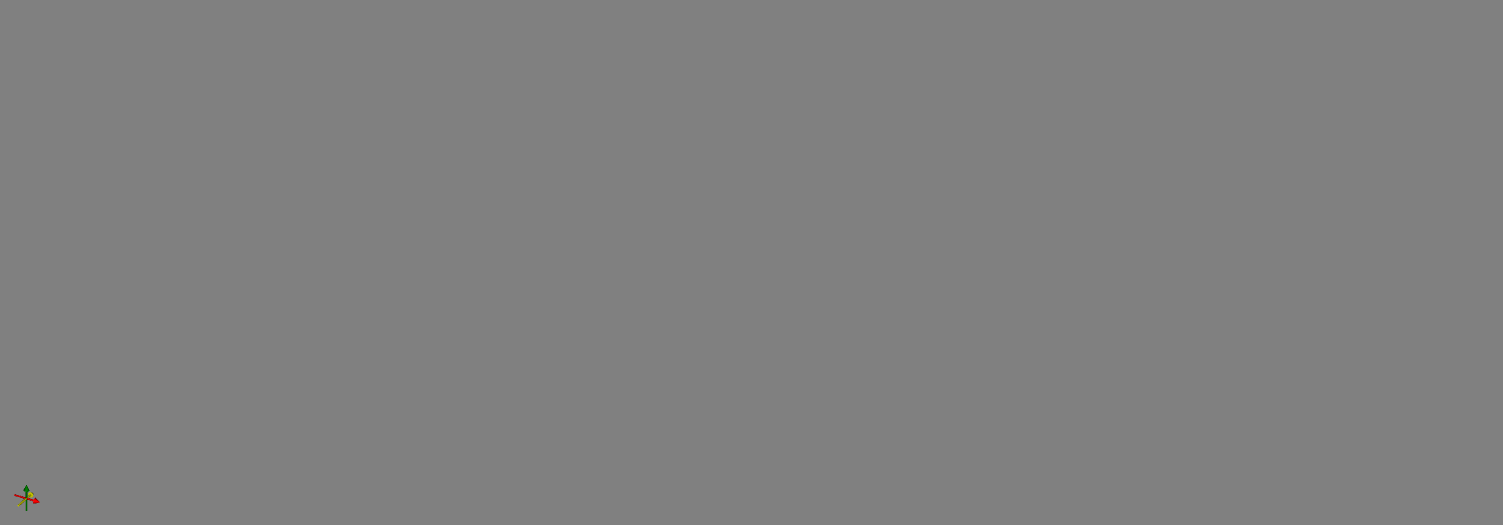
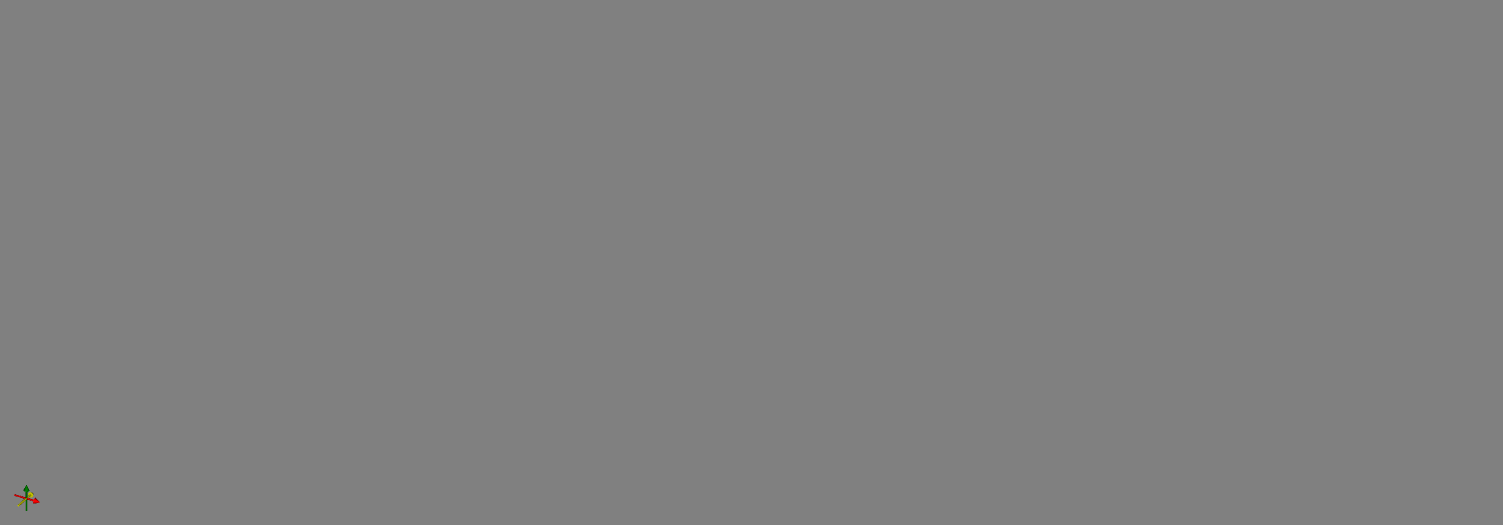

In [15]:
# View the image (or point clouds or polygons or numpy arrays or ...) using itkWidgets
#    Note after the load completes, it takes ~20 seconds for the data to 
#    appear in Colab and Sagemaker. Also, the display is a multi-resolution
#    display, so first coarse (and dim) versions of the data will be loaded,
#    and then a final high-resolution version - due to data transfer 
#    limitations on Colab and Sagemaker.

viewerA = view(dicom_image)


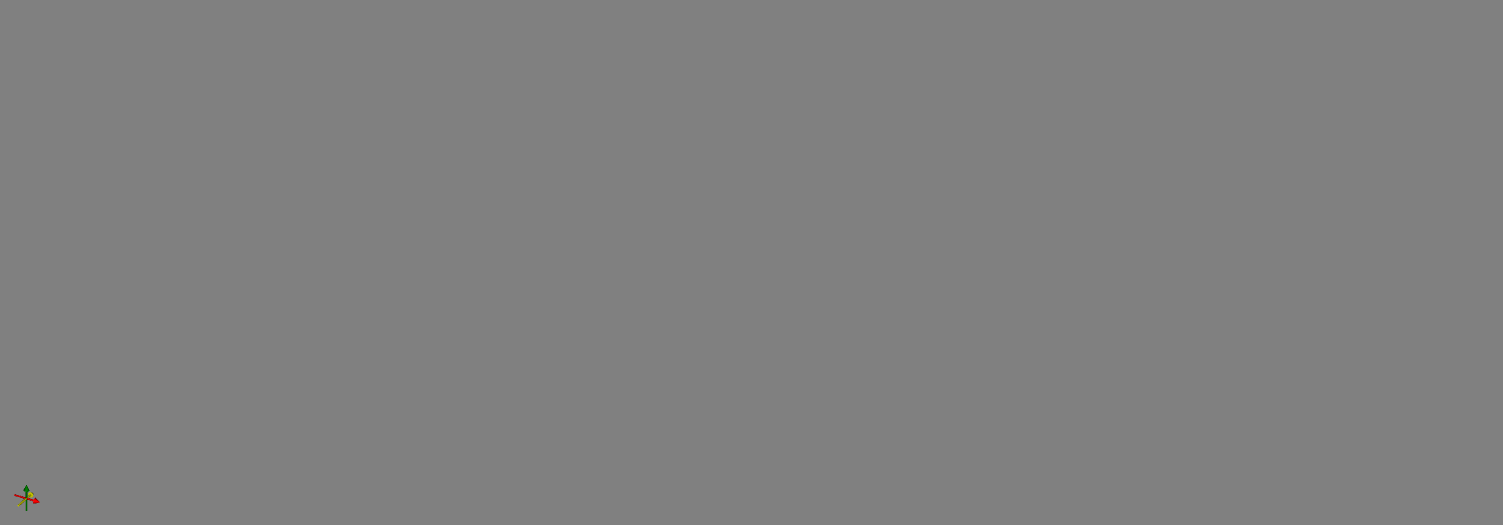
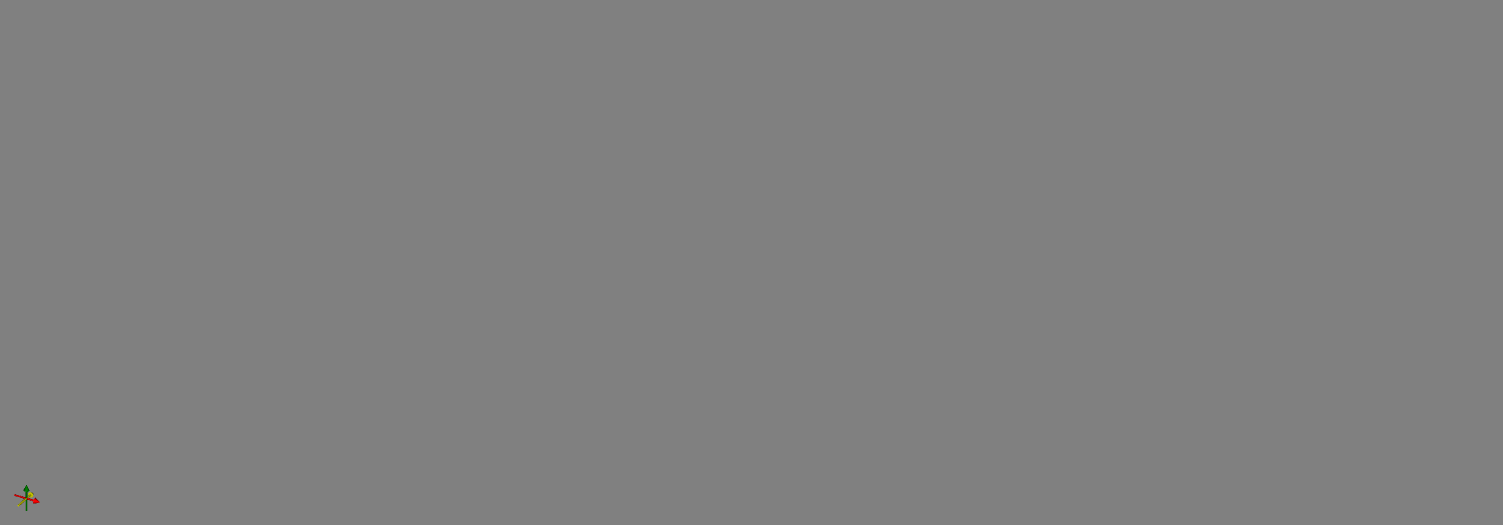

In [16]:
dicom_image_blah = itk.imread("tciaDownload/1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315/1-64.dcm", itk.F)
new_spacing = list(dicom_image_blah.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_blah.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image_blah2 = itk.resample_image_filter(Input=dicom_image_blah,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_blah.GetOrigin(), 
                                        output_direction=dicom_image_blah.GetDirection(),
                                        size=new_size)
viewerZ = view(dicom_image_blah2)

Looking into information about DICOM format from here: https://medium.com/analytics-vidhya/dicom-and-deep-learning-63373e99d79a

The "image" has four components:
* pixel depth (bits/pixel)
* pixel interpretation (monochrome vs color, samples/pixel, # of channels)
* metadata (patient info, date, etc.)
* pixel data (the actual image data)

Trying their method for extracting just the pixel array now...

In [18]:
# Install and import PyDICOM, then store file paths in list

!{sys.executable} -m pip install pydicom

import pydicom as di 
import os
from os import listdir
PathDicom = "tciaDownload"
DCMFiles = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():
            DCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
Number of (.dcm) files = 128


In [19]:
# Extract pixel data from image files

Images1 = []
for k in DCMFiles:
    Images = di.read_file(k,force=True)
    Images1.append(Images.pixel_array)

In [ ]:
# Here we demonstrate how to programmatically set some of the common cinematic volume rendering options

viewerA.set_background_color([0,0,0])
viewerA.set_image_color_map("CT-Muscle")
viewerA.set_image_volume_scattering_blend(0.2)
viewerA.set_image_volume_sample_distance(0.1)
viewerA.set_image_shadow_enabled(True)
viewerA.set_image_gradient_opacity(0.4)
viewerA.set_image_gradient_opacity_scale(0.5)
viewerA.set_image_color_range([-250,500])

# ...and we open the user interface panel so that you can keep manipulating it
viewerA.set_ui_collapsed(False)

## 4.B. Visualization of numpy arrays

Numpy arrays are perhaps the most common form of representing and processing images in notebooks, however they are
incomplete representations of medical images, so they should be used cautiously.  They do not include meta-data necessary
to map the array to physical space (e.g., voxel spacing, origin, and axis directions).  

So, if we simply convert the dicom data to numpy arrays without consideration of its x, y, and z spacing, then visualizations of that numpy data and subsequent image analyses (and particularly image registration) may be confounded.  So, first we resample the dicom image to isotropic voxels and then visualize it.


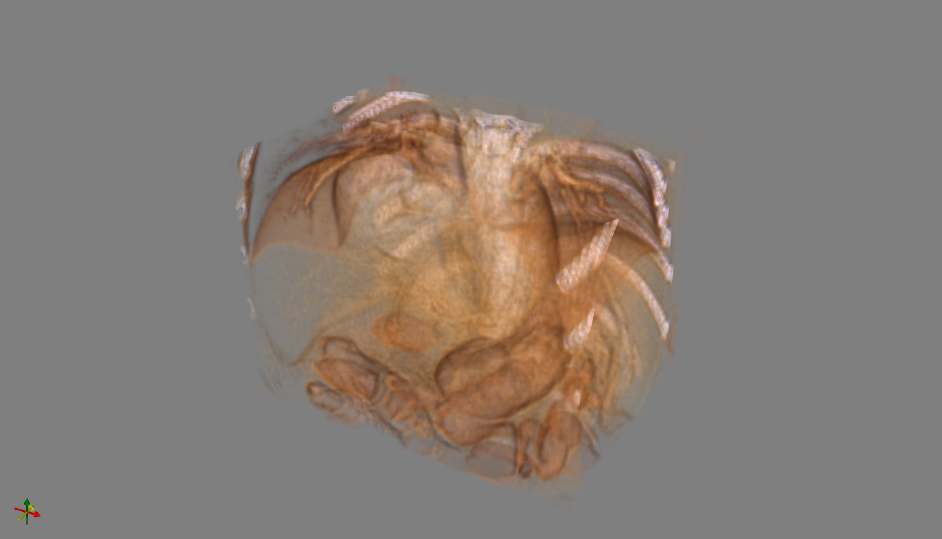
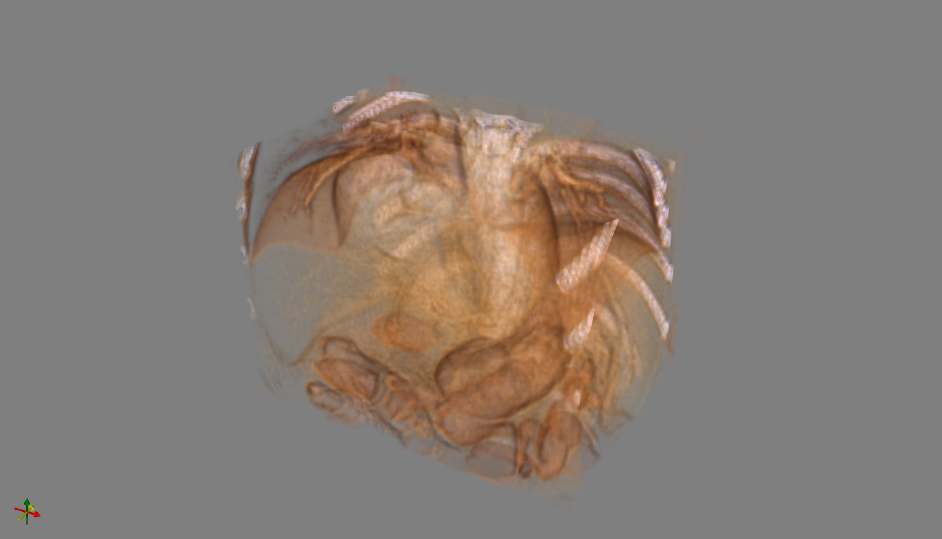

<IPython.core.display.Javascript object>

In [ ]:
# Here we use an ITK filter to resample and crop the original dicom image to a smaller region,
#    to save time and memory for this demo.
dicom_image_iso = itk.resample_image_filter(Input=dicom_image_large,
                                            output_spacing=[2,2,2], 
                                            output_origin=dicom_image.GetOrigin()+[50,80,260], 
                                            output_direction=dicom_image.GetDirection(),
                                            size=[100,75,75])

# Then convert that isotropic image to a numpy array for subsequent processing...
dicom_array_iso = itk.GetArrayFromImage(dicom_image_iso)

# The data now better represents the anatomic properties, but that representation in numpy is still
#    incomplete, since the 2mmx2mmx2mm spacing, origin, and orientation of the data is lost.
view(dicom_array_iso)

## 4.C. Visualization of pytorch tensors

The most common data structure used in deep learning network processing is PyTorch tensor.  However, like numpy arrays, tensors
do not contain the physical attributes of the data, so visualizations will not accurately reflect physical anatomy.

The good news is that MONAI offers meta-tensors that can be used interchangably with PyTorch tensors, but they also maintain
the physical acquisition parameters.  See other notebooks in this repository for demos and visualizations involving MONAI meta-tensors.


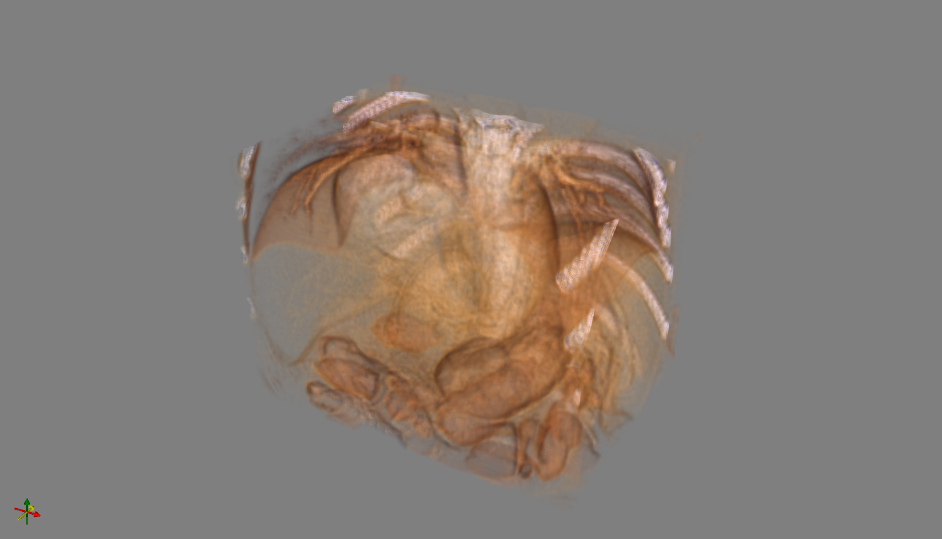
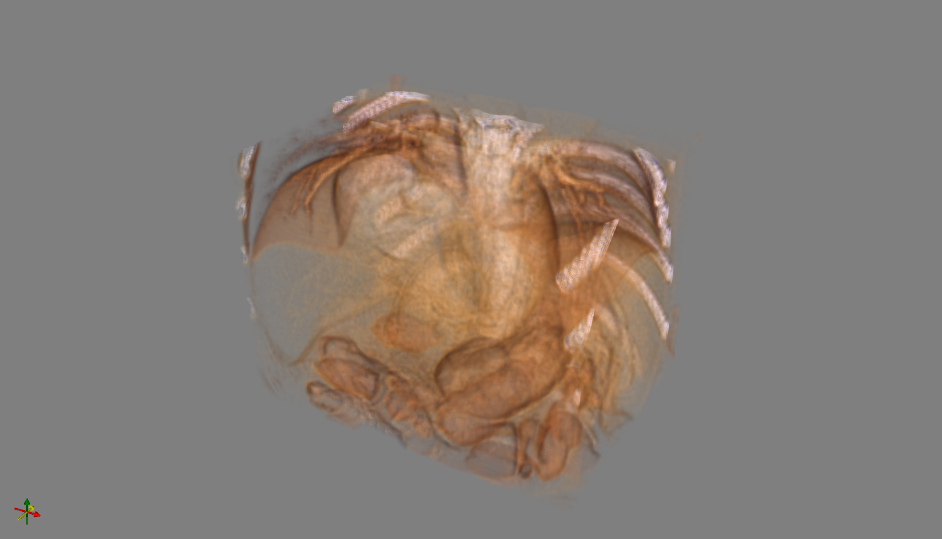

<IPython.core.display.Javascript object>

In [ ]:
# Convert the numpy array to a torch tensor
dicom_tensor = torch.tensor(dicom_array_iso)

viewerC = view(dicom_tensor)

## 4.D. Visualization of images and overlays

Overlays are common in TCIA data, particularly when used for AI research.  For example, overlays (aka labelmaps, aka label_images)
represent segmentations used in training or produced by deep learning systems.  Here we demonstrate the visualization of overlays
using itkWidgets.   For reading overlays from DICOM SEG, RTStruct, and STL files, refer to other notebooks in this repository.

In [ ]:
dicom_threshold_iso = itk.BinaryThresholdImageFilter(Input=dicom_image_iso, LowerThreshold=300, UpperThreshold=1000, OutsideValue=0, InsideValue=1)
arr = itk.GetArrayFromImage(dicom_threshold_iso)


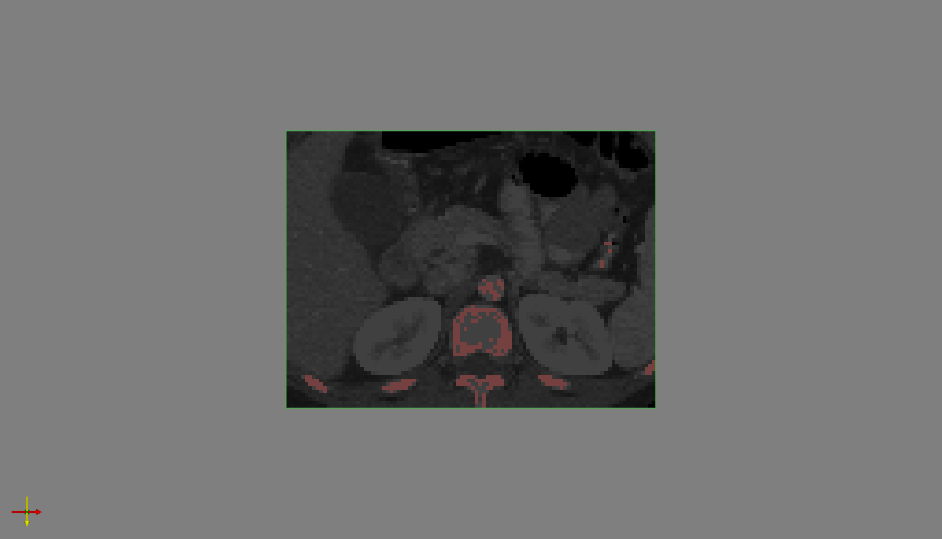
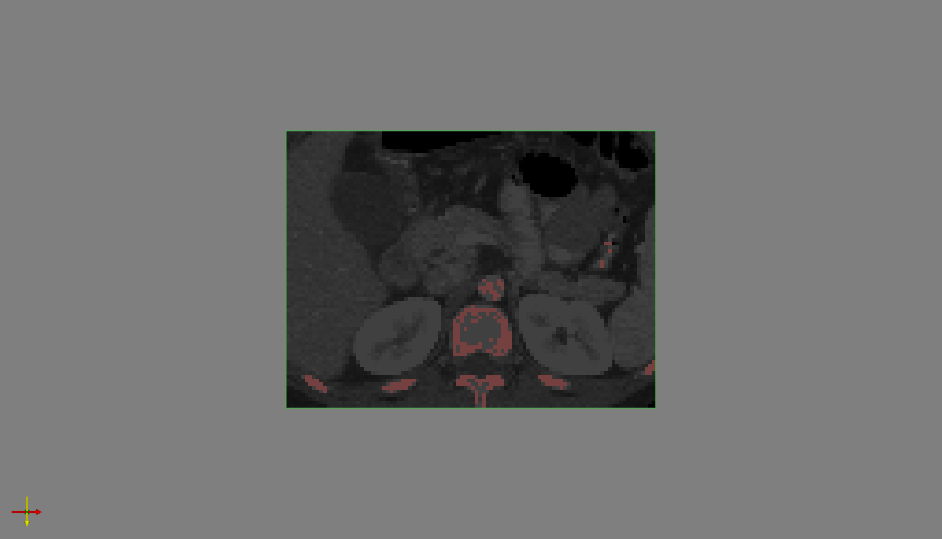

<IPython.core.display.Javascript object>

In [ ]:
viewerD = view(image=dicom_image_iso, label_image=dicom_threshold_iso)

In [ ]:
viewerD.set_image_color_map("Grayscale")
viewerD.set_image_color_range([-500,200])
viewerD.set_label_image_blend(0.5)
viewerD.set_view_mode('ZPlane')
#viewerD.set_z_slice(-134)

# Acknowledgements

TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

If you leverage this notebook or any TCIA datasets in your work please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to TCIA citation provided below!

This notebook was created by [Stephen Aylward (Kitware)](https://www.kitware.com/stephen-aylward/), [Justin Kirby (Frederick National Laboratory for Cancer Research)](https://www.linkedin.com/in/justinkirby82/), [Brianna Major (Kitware)](https://www.kitware.com/brianna-major/), and [Matt McCormick (Kitware)](https://www.kitware.com/matt-mccormick/).   The creation of this notebook was funded, in part, by NIBIB and NIGMS R01EB021396,
NIBIB R01EB014955, NCI R01CA220681, and NINDS R42NS086295.

If you have any questions, suggestions, or issues with itkWidgets, please post them on the [itkwidget issue tracker](https://github.com/InsightSoftwareConsortium/itkwidgets/issues) or feel free to email us at kitware@kitware.com.

## Data Citation
The data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Van Heteren, J., Vo, N.-J., & Schmidt, T. G. (2021). Pediatric Chest/Abdomen/Pelvic CT Exams with Expert Organ Contours (Pediatric-CT-SEG) (Version 2) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.X0H0-1706

## Publication Citation
The data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Heteren, J., Vo, N., & Schmidt, T. G. (2022). Pediatric chest‐abdomen‐pelvis and abdomen‐pelvis CT images with expert organ contours. In Medical Physics (Vol. 49, Issue 5, pp. 3523–3528). Wiley. https://doi.org/10.1002/mp.15485

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7